<p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Home Credit Default Risk Competition</p>

比赛链接： https://www.kaggle.com/c/home-credit-default-risk

这是一个标准的监督分类任务：

* __监督__：该项目的目的是使用贷款申请历史数据来预测申请人是否能够偿还贷款。
* __分类__：TARGET是一个二元变量，0 (准时还贷), 1 (还贷困难)

**[评估指标: ROC AUC](https://zhuanlan.zhihu.com/p/81202617)**

- ROC曲线

以FPR和TPR为横纵坐标轴，(ROC) 曲线绘制了真阳性率与假阳性率（误报率）的关系图。

纵轴：TPR=正例分对的概率 = TP/(TP+FN)，就是查全率，又名召回率。

横轴：FPR=负例分错的概率 = FP/(FP+TN)，本来是0 咱们预测是1的样本在所有本来是0的样本中的概率。<br>
![](https://www.statisticshowto.com/wp-content/uploads/2016/08/ROC-curve.png)

- AUC

ROC曲线下的面积叫AUC，可以评价模型能够在多大程度上区分类别。AUC 越高，模型预测 0 为 0 和 1 为 1 的效果越好。

特征工程参考：https://www.kaggle.com/jsaguiar/lightgbm-7th-place-solution <br>
特征选择参考：https://www.kaggle.com/hikmetsezen/base-model-with-0-804-auc-on-home-credit

在特征构造上，主要从以下几方面入手：<br>
- 基于业务的特征上，用金钱、时间、评分上的数据构造差值、占比特征。
- 统计特征上，根据分类变量(行业/贷款是否活跃/申请是否通过/贷款类型)对数值特征进行分组统计; 根据id对数值特征和分类特征进行分组统计。
- 固定时间窗，对过去12/24/36/60个月的贷款还款特征进行统计。

在特征选择上，通过限定auc去掉一批不重要的特征。

在模型训练上，选择LightGBM单模进行5折交叉验证和训练预测，采用optuna调参神器优化超参数，输出submission和最重要的15个特征。

最终Public Score分数最高为0.80109, Private Score最高分数为0.79624。

In [1]:
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
import re
import gc
import time
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 一、特征工程

分析每张表的数据, 构建特征并保存; 定义特征选择函数,去掉不重要的特征; 将所有表的特征通过Left Join连接到一起。

## 表1: application_train/test 
主要数据客户申请表, 包含目标变量(是否违约), 用户贷款信息、身份特征、外部评分几个方面信息。

身份特征：客户基本信息(性别, 年龄, 家庭, 学历, 职业, 行业, 居住状况), 客户财务信息(年收入, 房/车情况)。<br>
贷款信息：申请贷款信息(贷款类型, 贷款总额, 年金), 申请时提供的资料。<br>
外部评分: EXT_SOURCE 三个特征与目标均呈负相关，随着值的增加，客户更有可能偿还贷款。<br>   

1、数值特征上，通过加减乘除/分箱构造新特征, 主要包括贷款/收入/时间占比特征，外部评分交互和统计特征。<br> 
2、根据分类变量(行业/职业/学历/年龄段/性别)等对数值变量(收入/贷款额/年金/外部评分)进行分组统计。<br> 
3、对分类变量采用LabelEncoder标签编码方式。

In [2]:
def application_train_test(nan_as_category = False):
    # 读取合并数据
    df = pd.read_csv('input/application_train.csv', nrows= None)
    test_df = pd.read_csv('input/application_test.csv', nrows= None)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # 可选：删除 4行训练集 CODE_GENDER=XNA 
    df = df[df['CODE_GENDER'] != 'XNA']
    # 标记文档特征 - 计数和峰度
    docs = [_f for _f in df.columns if 'FLAG_DOC' in _f]
    live = [_f for _f in df.columns if ('FLAG_' in _f) & ('FLAG_DOC' not in _f) & ('_FLAG_' not in _f)]
    df['NEW_DOC_IND_KURT'] = df[docs].kurtosis(axis=1)
    df['NEW_LIVE_IND_SUM'] = df[live].sum(axis=1)
    # 工作时限：用缺失值替换异常值
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # 年龄段分类
    def get_age_label(days_birth):
        'Return the age group label (int). '
        age_years = abs(days_birth)/ 365
        if age_years <= 25: return 1
        elif age_years <= 30: return 2
        elif age_years <= 35: return 3
        elif age_years <= 40: return 4
        elif age_years <= 45: return 5
        elif age_years <= 50: return 6
        elif age_years <= 55: return 7
        elif age_years <= 60: return 8
        elif age_years <= 65: return 9
        else: return 10
    df['AGE_RANGE'] = df['DAYS_BIRTH'].apply(lambda x: get_age_label(x))  
    inc_by_org = df[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']
    df['NEW_INC_BY_ORG'] = df['ORGANIZATION_TYPE'].map(inc_by_org)
    
    # 1贷款占比
    df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['NEW_CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    #贷款年金相对信用金额的百分比
    df['ANNUITY_CREDIT_PERC'] = df['AMT_ANNUITY'] / df['AMT_CREDIT'] 
    #消费贷相对信用金额的百分比
    df['GOODS_CREDIT_PERCENT'] =df['AMT_GOODS_PRICE'] / df['AMT_CREDIT']
    
    # 2收入占比: 贷款年金/贷款金额相对于客户收入的百分比 
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['NEW_ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / (1 + df['AMT_INCOME_TOTAL']) #+1？
    df['NEW_CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    ## add
    df['NEW_INCOME_TO_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED'] 
    df['NEW_INCOME_TO_BIRTH_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH'] 
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['NEW_INC_PER_CHLD'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    
    # 3时间占比特征
    df['NEW_EMPLOY_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['NEW_CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['NEW_CAR_TO_EMPLOY_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    df['NEW_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
    df['NEW_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']
    df['ID_TO_BIRTH_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
    
    # external_sources交互项、统计特征
    df['NEW_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['NEW_SOURCE_WEIGHT'] = df.EXT_SOURCE_1 * 2 + df.EXT_SOURCE_2 * 3 + df.EXT_SOURCE_3 * 4
    for function_name in ['min', 'max', 'sum', 'mean', 'nanmedian']:
        df['NEW_SOURCE_{}'.format(function_name.upper())] = eval('np.{}'.format(function_name))(
            df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)
    df['NEW_SCORES_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    df['NEW_SCORES_STD'] = df['NEW_SCORES_STD'].fillna(df['NEW_SCORES_STD'].mean())
   
    # add features
    df['CHILDREN_RATIO'] = df['CNT_CHILDREN'] / df['CNT_FAM_MEMBERS']
    df['CNT_NOT_CHILD'] = df['CNT_FAM_MEMBERS'] - df['CNT_CHILDREN']
    df['INCOME_PER_NOT_CHILD'] = df['AMT_INCOME_TOTAL'] / df['CNT_NOT_CHILD']
    df['CREDIT_PER_PERSON'] = df['AMT_CREDIT'] / df['CNT_FAM_MEMBERS']
    df['CREDIT_PER_CHILD'] = df['AMT_CREDIT'] / (1 + df['CNT_CHILDREN'])
    df['CREDIT_PER_NOT_CHILD'] = df['AMT_CREDIT'] / df['CNT_NOT_CHILD']
    
    #  根据分类变量(行业/职业/学历/年龄段/性别)等对数值变量(收入/贷款额/年金/外部评分)进行分组统计
    group = ['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'AGE_RANGE', 'CODE_GENDER']
    df = do_median(df, group, 'NEW_SOURCE_MEAN', 'GROUP_EXT_SOURCES_MEDIAN')
    df = do_std(df, group, 'NEW_SOURCE_MEAN', 'GROUP_EXT_SOURCES_STD')
    df = do_mean(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_MEAN')
    df = do_std(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_STD')
    df = do_mean(df, group, 'NEW_CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_MEAN')
    df = do_std(df, group, 'NEW_CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_STD')
    df = do_mean(df, group, 'AMT_CREDIT', 'GROUP_CREDIT_MEAN')
    df = do_mean(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_MEAN')
    df = do_std(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_STD')
    
    # 二分类特征的编码 (0 or 1)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with LabelEncoder
    df, le_encoded_cols = label_encoder(df, None)     
    del test_df; gc.collect()
    return df

## 表2：bureau/bureau_balance 
历史信用记录,包含客户在征信中心的信用记录, 违约金额, 违约时间等, 以时间序列(按月)的形式进行记录。

1、对时间序列进行聚合求汇总统计量。根据id对数值特征和分类特征进行分组统计。<br>
2、根据分类变量(Active and closed loans)和主要贷款类型等对数值变量进行分组统计。<br>
3、固定时间窗: 离本次申请最近12个月的贷款特征。<br>

In [3]:
def bureau_and_balance(nan_as_category = True):
    bureau = pd.read_csv('input/bureau.csv', nrows = None)
     # bureau 贷款和欠款、期限和实际结束日期的差异和占比
    bureau['DEBT_CREDIT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
    bureau['DEBT_PERC'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_CREDIT_SUM_DEBT']
    bureau['ENDDATE_DIF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
    bureau['CREDIT_TO_ANNUITY_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_ANNUITY'] #add
    
    bb = pd.read_csv('input/bureau_balance.csv', nrows = None)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category = nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category = nan_as_category)
    # bureau_balance 编码分类特征，聚合时间特征，合并数据集
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # numeric features
    num_aggregations = {
        'DAYS_CREDIT': [ 'mean', 'var', 'min', 'max'], 
        'DAYS_CREDIT_ENDDATE': [ 'mean', 'min', 'max'], 
        'DAYS_CREDIT_UPDATE': ['mean', 'min', 'max'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean', 'max'],
        'AMT_CREDIT_SUM': [ 'mean', 'sum', 'max'], 
        'AMT_CREDIT_SUM_DEBT': [ 'mean', 'sum', 'max'], 
        'AMT_CREDIT_SUM_OVERDUE': ['mean', 'sum', 'max'], 
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
        'DEBT_CREDIT_DIFF': ['mean', 'sum'], 
        'ENDDATE_DIF': ['mean'], 
    }
    # categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - 数值特征聚合
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    add_agg= {'DEBT_PERC': ['mean'],'CREDIT_TO_ANNUITY_RATIO': ['mean']}
    active_agg = active.groupby('SK_ID_CURR').agg({**num_aggregations, **add_agg})
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - 数值特征聚合
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    # Ratios: total debt/total credit and active loans debt/ active loans credit
    bureau_agg['BURO_DEBT_CREDIT_RATIO'] = bureau_agg['BURO_AMT_CREDIT_SUM_DEBT_SUM'] / bureau_agg['BURO_AMT_CREDIT_SUM_SUM']
    bureau_agg['ACTIVE_DEBT_CREDIT_RATIO'] = bureau_agg['ACTIVE_AMT_CREDIT_SUM_DEBT_SUM']/bureau_agg['ACTIVE_AMT_CREDIT_SUM_SUM']

     # 主要贷款类型的分组统计 BUREAU_LOAN_TYPE_AGG
    BUREAU_LOAN_TYPE_AGG = {
    'DAYS_CREDIT': ['mean', 'max'],
    'AMT_CREDIT_SUM': ['mean', 'max'], 
    'AMT_CREDIT_SUM_DEBT': ['mean', 'max'],
    'DAYS_CREDIT_ENDDATE': ['max'],    
    'AMT_CREDIT_MAX_OVERDUE': ['mean', 'max'],
    'DEBT_PERC': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'] } 
    for credit_type in ['Consumer credit', 'Credit card']: #'Mortgage', 'Car loan', 'Microloan'
        type_df = bureau[bureau['CREDIT_TYPE_' + credit_type] == 1]
        prefix = 'BURO_' + credit_type.split(' ')[0].upper() + '_'
        bureau_agg = group_and_join(type_df, bureau_agg, prefix, BUREAU_LOAN_TYPE_AGG)
        del type_df; gc.collect()
        
    # 基于时间的聚合：最近12个月
    BUREAU_TIME_AGG = {
    'AMT_CREDIT_SUM': ['max', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
    'DEBT_PERC': ['mean'], 
    'DEBT_CREDIT_DIFF': ['mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],} 
    for months in [12]: #6, 
        prefix = "BUREAU_LAST{}M_".format(months)
        last_months_df = bureau[bureau['DAYS_CREDIT'] >= -30*months]
        bureau_agg = group_and_join(last_months_df, bureau_agg, prefix, BUREAU_TIME_AGG)
        del last_months_df; gc.collect()
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

## 表3：previous_applications  
历史申请记录(申请信息, 申请结果)<br>

1、构建申请和批准额度的占比和差值特征。根据id对数值特征和分类特征进行分组统计。<br>
2、根据分类变量(申请是否通过-批准和拒绝/主要贷款类型)等对数值特征进行聚合汇总。<br>
3、固定时间窗: 最近12/24个月的贷款统计特征。

In [4]:
def previous_applications(nan_as_category = True):
    prev = pd.read_csv('input/previous_application.csv', nrows = None)
    # One-hot 编码 最重要的分类特征 
    ohe_columns = [
        'NAME_CONTRACT_STATUS', 'NAME_CONTRACT_TYPE', 'CHANNEL_TYPE',
        'NAME_TYPE_SUITE', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
        'NAME_PRODUCT_TYPE', 'NAME_CLIENT_TYPE']
    prev, cat_cols = one_hot_encoder(prev, ohe_columns, nan_as_category= False)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # 申请额度和批准额度的占比和差值
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    prev['APP_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
    prev['CREDIT_TO_ANNUITY_RATIO'] = prev['AMT_CREDIT']/prev['AMT_ANNUITY']
    prev['DOWN_PAYMENT_TO_CREDIT'] = prev['AMT_DOWN_PAYMENT'] / prev['AMT_CREDIT']
    # Interest ratio (simplified) 先前申请的利率（简化）
    total_payment = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
    prev['SIMPLE_INTERESTS'] = (total_payment/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']
    
    # 数值特征
    num_aggregations = {
        'AMT_ANNUITY': [ 'max', 'mean', 'min'],  
        'AMT_APPLICATION': ['min', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean','var'],  
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean', 'sum'],  
        'DAYS_DECISION': ['min', 'max', 'mean', 'var'],  
        'CNT_PAYMENT': ['mean', 'sum', 'max','var'],  
        'SK_ID_PREV': ['nunique'],  
        'DAYS_TERMINATION': ['max'],  
        'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],  
        'APP_CREDIT_DIFF': ['max'] }  
    # 分类特征  
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    
    # 批准申请 - 数值特征分组统计
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    add_agg = {'SIMPLE_INTERESTS': ['min', 'max', 'mean', 'var'], 'DAYS_TERMINATION': [ 'max'],
              'DAYS_LAST_DUE_1ST_VERSION': ['min', 'mean'],}  
    approved_agg = approved.groupby('SK_ID_CURR').agg({**num_aggregations, **add_agg})
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')

    # 拒绝申请 - 数值特征分组统计
    PREVIOUS_REFUSED_AGG = {
        'AMT_APPLICATION': ['max', 'min', 'mean'],
        'AMT_CREDIT': ['min', 'max'], 
        'APP_CREDIT_PERC': ['min', 'mean'], 
        'DAYS_DECISION': ['min', 'max', 'mean', 'var'],  
        'CNT_PAYMENT': ['mean', 'sum', 'max','var'],  
        'AMT_ANNUITY': ['mean'],  
        'AMT_GOODS_PRICE': ['mean'],  
        'HOUR_APPR_PROCESS_START': ['mean'],
        'APP_CREDIT_DIFF': ['min', 'max', 'mean', 'var']}
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(PREVIOUS_REFUSED_AGG) # num_aggregations
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')

    # 消费贷款和现金贷款的汇总
    PREVIOUS_LOAN_TYPE_AGG = {
    'AMT_CREDIT': ['sum'],
    'AMT_ANNUITY': ['mean', 'max'],
    'SIMPLE_INTERESTS': ['min', 'mean', 'max', 'var'],
    'APP_CREDIT_DIFF': ['min', 'var'],
    'APP_CREDIT_PERC': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['max'],
    'DAYS_LAST_DUE_1ST_VERSION': ['max', 'mean'],
    'CNT_PAYMENT': ['mean'],}
    for loan_type in ['Consumer loans', 'Cash loans']:
        type_df = prev[prev['NAME_CONTRACT_TYPE_{}'.format(loan_type)] == 1]
        prefix = 'PREV_' + loan_type.split(" ")[0] + '_'
        prev_agg = group_and_join(type_df, prev_agg, prefix, PREVIOUS_LOAN_TYPE_AGG)
        del type_df; gc.collect()
        
    #过去 x 个月的贷款汇总
    PREVIOUS_TIME_AGG = {
    'AMT_CREDIT': ['sum'],
    'AMT_ANNUITY': ['mean', 'max'],
    'SIMPLE_INTERESTS': ['mean', 'max'],
    'DAYS_DECISION': ['min', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'], #最后到期日
    'APP_CREDIT_DIFF': ['min'], #申请额度和批准额度的差值
    'APP_CREDIT_PERC': ['min', 'max', 'mean'], #申请额度和批准额度的占比
 }
    for months in [12, 24]:
        last_months_df = prev[prev['DAYS_DECISION'] >= -30*months]
        prefix = 'PREV_LAST{}M_'.format(months)
        prev_agg = group_and_join(last_months_df, prev_agg, prefix, PREVIOUS_TIME_AGG)
        del last_months_df; gc.collect()
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

## 表4：POS_CASH_balance 
客户在数据库中POS(point of sales)和现金贷款历史(月数据),包含了客户已付款和未付款的情况。<br>

1、根据id对数值特征和分类特征进行分组统计。<br>
2、剩余分期付款次数和相对分期付款总次数的占比统计特征。<br>

In [5]:
def pos_cash(nan_as_category = True):
    pos = pd.read_csv('input/POS_CASH_balance.csv', nrows = None)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
     # Aggregate by SK_ID_CURR
    aggregations = {
    'MONTHS_BALANCE': ['max', 'mean', 'size', 'min', 'var', 'sum'],
    'SK_DPD': ['max', 'mean'],
    'SK_DPD_DEF': ['max', 'mean', 'sum'] 
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts 每个账户申请次数
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()

    # Sort and group by SK_ID_PREV 
    gp = pos.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE']).groupby('SK_ID_PREV') #惰性对象
    #剩余分期付款次数（未来分期付款）和占总数的百分比
    df = pd.DataFrame()
    df['SK_ID_CURR'] = gp['SK_ID_CURR'].first()
    df['POS_REMAINING_INSTALMENTS'] = gp['CNT_INSTALMENT_FUTURE'].last()
    df = df.groupby('SK_ID_CURR').sum() 
    pos_agg = pos_agg.join(df, how='left', on='SK_ID_CURR')
    del pos, gp, df; gc.collect()
    return pos_agg

## 表5：installments_payments 
先前信用卡的还款记录,包含客户的还款情况(还款日期, 是否逾期, 还款金额, 是否欠款等)。

1、计算金额和时间上的差值，构建欠款、逾期特征，标记明显的延迟付款特征。<br>
2、根据id对数值特征和分类特征进行分组统计。<br>
3、固定时间窗: 最近36/60个月的分期付款统计特征。

In [6]:
def installments_payments(nan_as_category = True):
    ins = pd.read_csv('input/installments_payments.csv', nrows = None)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # 欠款特征：支付金额和分期金额的占比和差值
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # 是否预期：Days past due and days before due 逾期天数和到期前天数（无负值）
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0) #late payment
    # 延迟付款百分比
    ins['LATE_PAYMENT_RATIO'] = ins.apply(lambda x: x['PAYMENT_PERC'] if x['DBD'] == 1 else 0, axis=1)
    # 标记数值较大的逾期付款
    ins['SIGNIFICANT_LATE_PAYMENT'] = ins['LATE_PAYMENT_RATIO'].apply(lambda x: 1 if x > 0.05 else 0)
    # 标记超过7天的延迟付款
    ins['DPD_7'] = ins['DPD'].apply(lambda x: 1 if x >= 7 else 0)
    
    # 按 SK_ID_CURR 聚合
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum', 'var'], 
        'PAYMENT_PERC': [ 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': [ 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'], 
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum', 'min'],  
        'DAYS_INSTALMENT':['min', 'var', 'mean', 'sum'],
        'SIGNIFICANT_LATE_PAYMENT': ['mean', 'sum'],}  
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INS_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count id 帐户频数统计 等价于.count()
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    
    # 最近 x 个月的分期付款
    INSTALLMENTS_TIME_AGG = {
        'DAYS_ENTRY_PAYMENT': ['min', 'max', 'mean'],
        'AMT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DPD': ['max', 'mean', 'var'],
        'DBD': ['max', 'mean', 'var'],
        'DPD_7': ['mean'], 
        'LATE_PAYMENT_RATIO': ['mean'],    
        'SIGNIFICANT_LATE_PAYMENT': ['mean'],}  
    for months in [36, 60]:
        recent_prev_id = ins[ins['DAYS_INSTALMENT'] >= -30*months]['SK_ID_PREV'].unique()
        ins_recent = ins[ins['SK_ID_PREV'].isin(recent_prev_id)]
        prefix = 'INS_{}M_'.format(months)
        ins_agg = group_and_join(ins_recent, ins_agg, prefix, INSTALLMENTS_TIME_AGG)
    del ins
    gc.collect()
    return ins_agg

## 表6：credit_card_balance 
信用卡的收支历史(月数据),包含了客户消费次数, 消费金额等情况。

1、标记信用卡的延迟付款、限额等特征。<br>
2、根据id对数值特征和分类特征进行分组统计。<br>
3、固定时间窗: 每个信用卡申请的前1个月余额统计，最近12/24/48个月的分期付款统计特征。

In [7]:
def credit_card_balance(nan_as_category = True):
    cc = pd.read_csv('input/credit_card_balance.csv', nrows = None)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # Late payment <-- 'CARD_IS_DPD' 标记逾期付款
    cc['LATE_PAYMENT'] = cc['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    # Current payment / Min payment 当前支付金额/最低支付金额
    cc['PAYMENT_DIV_MIN'] = cc['AMT_PAYMENT_CURRENT'] / cc['AMT_INST_MIN_REGULARITY']
     # How much drawing of limit
    cc['DRAWING_LIMIT_RATIO'] = cc['AMT_DRAWINGS_ATM_CURRENT'] / cc['AMT_CREDIT_LIMIT_ACTUAL']
     # Amount used from limit 限制使用的金额
    cc['LIMIT_USE'] = cc['AMT_BALANCE'] / cc['AMT_CREDIT_LIMIT_ACTUAL']

    # Aggregations by SK_ID_CURR
    cols = [m for m in cc.columns if m not in ['SK_ID_PREV']] 
    cc_agg = cc[cols].groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count id 帐户频数统计 
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()

    # 每个信用卡申请的最后一个月余额 Last month balance of each credit card application-group and merge
    last_ids = cc.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()
    last_months_df = cc[cc.index.isin(last_ids)]
    agg_df = last_months_df.groupby('SK_ID_CURR').agg({'AMT_BALANCE': ['mean', 'max']}) #.reset_index() 
    agg_df.columns = pd.Index(['{}{}_{}'.format('CC_LAST_', e[0], e[1].upper())for e in agg_df.columns.tolist()])
    cc_agg = cc_agg.join(agg_df, how='left', on='SK_ID_CURR')
    
    # 过去 x 个月的信用卡数据统计
    for months in [12,24,48]:  
        cc_prev_id = cc[cc['MONTHS_BALANCE'] >= -months]['SK_ID_PREV'].unique()
        cc_recent = cc[cc['SK_ID_PREV'].isin(cc_prev_id)]
        agg_df = cc_recent.groupby('SK_ID_CURR').agg({'CNT_DRAWINGS_ATM_CURRENT': ['mean'],
                                                    'SK_DPD': ['sum'], 
                                                    'AMT_BALANCE': ['mean', 'max'],
                                                    'LIMIT_USE': ['max', 'mean'] })  
        agg_df.columns = pd.Index(['{}{}_{}'.format('INS_{}M_'.format(months), e[0], e[1].upper())
                                       for e in agg_df.columns.tolist()])
        cc_agg = cc_agg.join(agg_df, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()
    return cc_agg

## 表之间的交互特征

In [8]:
def add_ratios_features(df):
    # CREDIT TO INCOME RATIO
    df['BURO_INCOME_CREDIT_RATIO'] = df['BURO_AMT_CREDIT_SUM_MEAN'] / df['AMT_INCOME_TOTAL']
    df['BURO_ACTIVE_CREDIT_TO_INCOME_RATIO'] = df['ACTIVE_AMT_CREDIT_SUM_SUM'] / df['AMT_INCOME_TOTAL']
    # PREVIOUS TO CURRENT CREDIT RATIO
    df['CURRENT_TO_APPROVED_CREDIT_MIN_RATIO'] = df['APPROVED_AMT_CREDIT_MIN'] / df['AMT_CREDIT']
    df['CURRENT_TO_APPROVED_CREDIT_MAX_RATIO'] = df['APPROVED_AMT_CREDIT_MAX'] / df['AMT_CREDIT']
    df['CURRENT_TO_APPROVED_CREDIT_MEAN_RATIO'] = df['APPROVED_AMT_CREDIT_MEAN'] / df['AMT_CREDIT']
    # PREVIOUS TO CURRENT ANNUITY RATIO
    df['CURRENT_TO_APPROVED_ANNUITY_MAX_RATIO'] = df['APPROVED_AMT_ANNUITY_MAX'] / df['AMT_ANNUITY']
    df['CURRENT_TO_APPROVED_ANNUITY_MEAN_RATIO'] = df['APPROVED_AMT_ANNUITY_MEAN'] / df['AMT_ANNUITY']
    df['PAYMENT_MIN_TO_ANNUITY_RATIO'] = df['INS_AMT_PAYMENT_MIN'] / df['AMT_ANNUITY']
    df['PAYMENT_MAX_TO_ANNUITY_RATIO'] = df['INS_AMT_PAYMENT_MAX'] / df['AMT_ANNUITY']
    df['PAYMENT_MEAN_TO_ANNUITY_RATIO'] = df['INS_AMT_PAYMENT_MEAN'] / df['AMT_ANNUITY']
    # PREVIOUS TO CURRENT CREDIT TO ANNUITY RATIO
    df['CTA_CREDIT_TO_ANNUITY_MAX_RATIO'] = df['APPROVED_CREDIT_TO_ANNUITY_RATIO_MAX'] / df[
        'NEW_CREDIT_TO_ANNUITY_RATIO']
    df['CTA_CREDIT_TO_ANNUITY_MEAN_RATIO'] = df['APPROVED_CREDIT_TO_ANNUITY_RATIO_MEAN'] / df[
        'NEW_CREDIT_TO_ANNUITY_RATIO']
    # DAYS DIFFERENCES AND RATIOS
    df['DAYS_DECISION_MEAN_TO_EMPLOYED'] = df['APPROVED_DAYS_DECISION_MEAN'] / df['DAYS_EMPLOYED']
    df['DAYS_DECISION_MEAN_TO_BIRTH'] = df['APPROVED_DAYS_DECISION_MEAN'] / df['DAYS_BIRTH']
    df['DAYS_CREDIT_MEAN_TO_BIRTH'] = df['BURO_DAYS_CREDIT_MEAN'] / df['DAYS_BIRTH']
    df['DAYS_CREDIT_MEAN_TO_EMPLOYED'] = df['BURO_DAYS_CREDIT_MEAN'] / df['DAYS_EMPLOYED']
    return df

# 二、特征选择

In [9]:
# 限定auc去掉不重要的特征
def ligthgbm_feature_selection(dataframe, index_cols, auc_limit=0.7):
    #规范修改编码名称中的特殊字符
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '_', x)) 
    clf = LGBMClassifier(random_state=0)
    train_df = dataframe[dataframe['TARGET'].notnull()]
    train_df_X = train_df.drop('TARGET', axis=1)
    train_df_y = train_df['TARGET']
    train_columns = [col for col in train_df_X.columns if col not in index_cols]

    max_auc_score = 1
    best_cols = []
    while max_auc_score > auc_limit:
        train_columns = [col for col in train_columns if col not in best_cols]
        clf.fit(train_df_X[train_columns], train_df_y)
        feats_imp = pd.Series(clf.feature_importances_, index=train_columns)
        max_auc_score = roc_auc_score(train_df_y, clf.predict_proba(train_df_X[train_columns])[:, 1])
        best_cols = feats_imp[feats_imp > 0].index.tolist()

    dataframe.drop(train_columns, axis=1, inplace=True)
    return dataframe

def data_post_processing(dataframe):
    print(f'the DATA POST-PROCESSING is beginning, the dataset has {dataframe.shape[1]} features')
    # 规范修改编码名称中的特殊字符
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '_', x))
    # Reduced memory usage
    dataframe = reduce_mem_usage(dataframe)
    print(f'pandas data types of features in the dataset are converted for a reduced memory usage')
    # Remove non-informative columns
    noninformative_cols = []
    for col in dataframe.columns:
        if len(dataframe[col].value_counts()) < 2: #唯一值个数<2
            noninformative_cols.append(col)
    dataframe.drop(noninformative_cols, axis=1, inplace=True)
    print(f'{dataframe.shape[1]} features are remained after removing non-informative features')
    # keep index related columns 保留的列
    index_cols = ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']
    dataframe = ligthgbm_feature_selection(dataframe, index_cols, auc_limit=0.7)
    print(f'the DATA POST-PROCESSING is ended!, now the dataset has a total {dataframe.shape[1]} features')
    gc.collect()
    return dataframe

#减少内存占用
def reduce_mem_usage(dataframe):
    m_start = dataframe.memory_usage().sum() / 1024 ** 2
    for col in dataframe.columns:
        col_type = dataframe[col].dtype
        if col_type != object:
            c_min = dataframe[col].min()
            c_max = dataframe[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    dataframe[col] = dataframe[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    dataframe[col] = dataframe[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    dataframe[col] = dataframe[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    dataframe[col] = dataframe[col].astype(np.int64)
            elif str(col_type)[:5] == 'float':
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    dataframe[col] = dataframe[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    dataframe[col] = dataframe[col].astype(np.float32)
                else:
                    dataframe[col] = dataframe[col].astype(np.float64)

    m_end = dataframe.memory_usage().sum() / 1024 ** 2
    return dataframe

In [10]:
# 功能性函数定义

# One-hot 编码分类特征 - get_dummies
def one_hot_encoder(df, categorical_columns=None, nan_as_category = True):
    original_columns = list(df.columns)
    # 如果不指定编码列名，那么编码所有类别特征
    if not categorical_columns:
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category) #编码空列
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns
# 标签编码分类特征 
def label_encoder(df, categorical_columns=None):
    """Encode categorical values as integers (0,1,2,3...) with pandas.factorize. """
    if not categorical_columns:
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    for col in categorical_columns:
        df[col], uniques = pd.factorize(df[col])
    return df, categorical_columns

# 统计合并功能
def group_and_join(df_to_agg, df_to_merge, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = df_to_agg.groupby(aggregate_by).agg(aggregations)
    agg_df.columns = pd.Index(['{}{}_{}'.format(prefix, e[0], e[1].upper()) for e in agg_df.columns.tolist()])
    return df_to_merge.join(agg_df, how='left', on= aggregate_by)
# 求均值、中值、标准差、求和
def do_mean(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].mean().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df
def do_median(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].median().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df
def do_std(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].std().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df
def do_sum(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].sum().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df

## 获取数据

In [11]:
def main():
    df = application_train_test()
    print("df shape:", df.shape)
    df = df.join(bureau_and_balance(), how='left', on='SK_ID_CURR')
    print('df with bureau:', df.shape)
    df = df.join(previous_applications(), how='left', on='SK_ID_CURR')
    print("df with Previous applications:", df.shape)
    df = df.join(pos_cash(), how='left', on='SK_ID_CURR')
    print("df with Pos-cash balance:", df.shape)
    df = df.join(installments_payments(), how='left', on='SK_ID_CURR')
    print("df with Installments payments:", df.shape)
    df = df.join(credit_card_balance(), how='left', on='SK_ID_CURR')
    print("df with Credit card balance:", df.shape)
    df = add_ratios_features(df)
    print("df with ratios_features:", df.shape)
    df = data_post_processing(df)
    return df
    
if __name__ == "__main__":
    df=main()

Train samples: 307511, test samples: 48744
df shape: (356251, 167)
df with bureau: (356251, 335)
df with Previous applications: (356251, 551)
df with Pos-cash balance: (356251, 574)
df with Installments payments: (356251, 646)
df with Credit card balance: (356251, 827)
df with ratios_features: (356251, 843)
the DATA POST-PROCESSING is beginning, the dataset has 843 features
pandas data types of features in the dataset are converted for a reduced memory usage
830 features are remained after removing non-informative features
the DATA POST-PROCESSING is ended!, now the dataset has a total 741 features


# 三、LGB模型训练 

按5折交叉验证进行训练，采用optuna调参神器优化超参数，输出submission和最重要的15个特征。

按指定类别变量和不指定类别变量2种方式进行训练，指定类别特征会获得一个相对较高的Private Score，不指定类别特征会获得一个较高的Public Score。

In [12]:
categorical_feature = ['CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE',
    'ORGANIZATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'NAME_TYPE_SUITE', 'WALLSMATERIAL_MODE']

In [13]:
def kfold_lightgbm(df, categorical_feature):
    # 划分训练/验证和测试数据
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df; gc.collect()
    # 5折交叉验证
    folds = KFold(n_splits= 5, shuffle=True, random_state=2021)
    # 创建数组来储存数据
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    # 特征
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV']]
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by optuna
        clf = LGBMClassifier(
            n_estimators= 10000, max_depth= 8, num_leaves = 44, 
            learning_rate= 0.03,  reg_alpha= 2.41,  reg_lambda= 0.81, 
            colsample_bytree= 0.8,  subsample= 0.8,  min_child_weight= 26,
            min_split_gain=0.02, silent=-1, verbose=-1, )
        if not categorical_feature:
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc',
                verbose= 200, early_stopping_rounds= 200)
        else:
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc',
                verbose= 200, early_stopping_rounds= 200,categorical_feature = categorical_feature)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        imp_df = pd.DataFrame({'feature':clf.booster_.feature_name(),
             'importance':clf.feature_importances_/ folds.n_splits}).sort_values(by=['importance'],ascending=False)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # 输出submission, 绘制重要特征 
    test_df['TARGET'] = sub_preds
    test_df[['SK_ID_CURR', 'TARGET']].to_csv("submission_1.csv", index= False)
    imp_df.to_csv('feature_importance.csv')
    display_importances(imp_df)
    return imp_df,test_df

def display_importances(imp_df):
    cols = list(imp_df['feature'][:15])
    best_features = imp_df.loc[imp_df.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features)
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

Starting LightGBM. Train shape: (307507, 741), test shape: (48744, 741)
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.830998	training's binary_logloss: 0.221177	valid_1's auc: 0.784436	valid_1's binary_logloss: 0.239451
[400]	training's auc: 0.864878	training's binary_logloss: 0.206424	valid_1's auc: 0.790527	valid_1's binary_logloss: 0.237252
[600]	training's auc: 0.888872	training's binary_logloss: 0.195208	valid_1's auc: 0.791652	valid_1's binary_logloss: 0.236817
[800]	training's auc: 0.907199	training's binary_logloss: 0.185617	valid_1's auc: 0.792333	valid_1's binary_logloss: 0.236654
[1000]	training's auc: 0.922684	training's binary_logloss: 0.17694	valid_1's auc: 0.792349	valid_1's binary_logloss: 0.236712
Early stopping, best iteration is:
[904]	training's auc: 0.915741	training's binary_logloss: 0.180968	valid_1's auc: 0.79256	valid_1's binary_logloss: 0.236627
Fold  1 AUC : 0.792560
Training until validation scores don't improve for 20

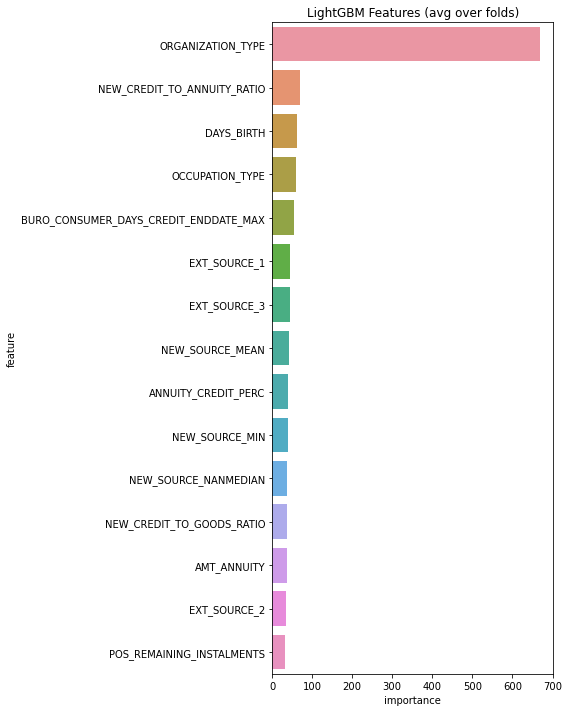

In [14]:
imp_df,test_df = kfold_lightgbm(df, categorical_feature)

将submission提交到kaggle,标记类别特征的模型最终Public Score分数为0.80019, Private Score分数为0.79624。

Starting LightGBM. Train shape: (307507, 741), test shape: (48744, 741)
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.828481	training's binary_logloss: 0.222061	valid_1's auc: 0.783921	valid_1's binary_logloss: 0.239494
[400]	training's auc: 0.860439	training's binary_logloss: 0.208324	valid_1's auc: 0.790528	valid_1's binary_logloss: 0.237085
[600]	training's auc: 0.883495	training's binary_logloss: 0.197765	valid_1's auc: 0.792367	valid_1's binary_logloss: 0.236473
[800]	training's auc: 0.901414	training's binary_logloss: 0.188893	valid_1's auc: 0.793109	valid_1's binary_logloss: 0.236245
[1000]	training's auc: 0.916777	training's binary_logloss: 0.180518	valid_1's auc: 0.793368	valid_1's binary_logloss: 0.236163
Early stopping, best iteration is:
[893]	training's auc: 0.908404	training's binary_logloss: 0.18512	valid_1's auc: 0.793424	valid_1's binary_logloss: 0.236142
Fold  1 AUC : 0.793424
Training until validation scores don't improve for 2

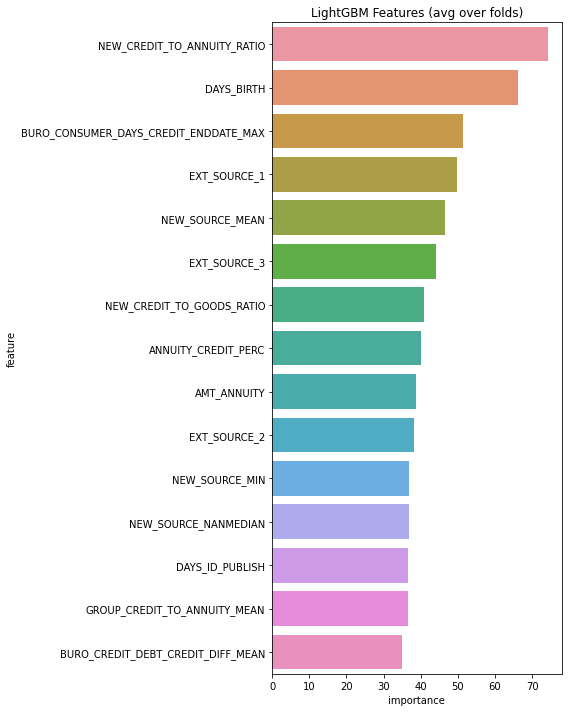

In [15]:
imp_df,test_df = kfold_lightgbm(df, categorical_feature=None)

将submission提交到kaggle,最终Public Score分数为0.80109, Private Score分数为0.79579。

## 特征解释

- 我们看到，最重要的数值特征是NEW_CREDIT_TO_ANNUITY_RATIO：贷款金额占年金的百分比。
最重要的分类特征是ORGANIZATION_TYPE：组织类型, 即行业。
- 其次，基于业务构建的特征BURO_CONSUMER_DAYS_CREDIT_ENDDATE_MAX(消费贷最大截止日期)和 DAYS_BIRTH(年龄), EXT_SOURCE外部评分特征进入了最重要的15个特征！ 